# **Tutorial** **Notebook** - *Deliverable 2*
This notebook is a tutorial on- \\
Deliverable 2: Example Notebook-I: \\
(2.A) **Importing** and **Placement** of FETs and other macros/Pcells with relative coordinates + Placing (and connecting) Via_stack on the ports of the FETs + encircling them with padrings (+and probably printing and explaining port names) \\
(2.B) **Routing** between those placed Vias with C_, L_, Straight_ and smart Routes and explaining the differences between these strategies, particularly with E/W/N/S angles (For Example, why C has to parallel but L has to be perpendicular) and *Placing and connecting PINs for future LVS runs + running successful DRCs*

## **Target** **Block**
### **Flipped Voltage Follwer Cell**
The Flipped Voltage Follower (FVF) is a widely used analog building block known for its low output impedance, fast transient response, and ability to deliver large output current while maintaining voltage buffering properties. It is commonly employed in analog circuit design, particularly in output stages, gain boosting, common-mode feedback circuits, and super class-AB OTAs. \\
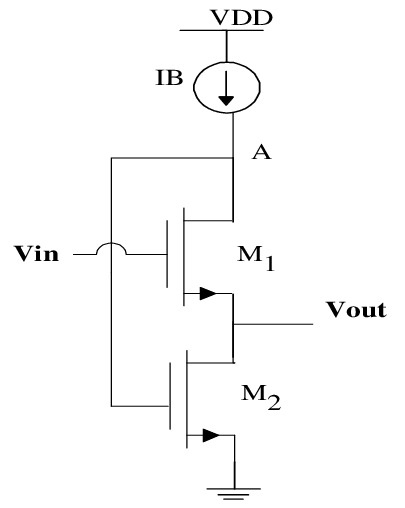

## **Step-by-step guide for layout generation**
### **Setting up the environment**

In [ ]:
# from glayout.flow.pdk.sky130_mapped import sky130_mapped_pdk as sky130
# from glayout.flow.pdk.gf180_mapped  import gf180_mapped_pdk  as gf180
# import gdstk
# import svgutils.transform as sg
# import IPython.display
# from IPython.display import clear_output
# import ipywidgets as widgets

# # Redirect all outputs here
# hide = widgets.Output()

# # Used to display gds file inline
# def display_gds(gds_file, scale = 3):
#   # Generate an SVG image
#   top_level_cell = gdstk.read_gds(gds_file).top_level()[0]
#   top_level_cell.write_svg('out.svg')
#   # Scale the image for displaying
#   fig = sg.fromfile('out.svg')
#   fig.set_size((str(float(fig.width) * scale), str(float(fig.height) * scale)))
#   fig.save('out.svg')

#   # Display the image
#   IPython.display.display(IPython.display.SVG('out.svg'))

# def display_component(component, scale = 3):
#   # Save to a GDS file
#   with hide:
#     component.write_gds("out.gds")
#   display_gds('out.gds', scale)

## **Layout generation**
Now that environment is set, let's go through the step by step procedure to generate LVS and DRC clean layout of a FVF cell.


In [12]:
from glayout.flow.pdk.mappedpdk import MappedPDK
from glayout.flow.pdk.sky130_mapped import sky130_mapped_pdk
from gdsfactory.cell import cell
from gdsfactory.component import Component
from gdsfactory import Component
from glayout.flow.primitives.fet import nmos, pmos, multiplier
from glayout.flow.pdk.util.comp_utils import evaluate_bbox, prec_center, prec_ref_center, align_comp_to_port
from glayout.flow.pdk.util.snap_to_grid import component_snap_to_grid
from glayout.flow.pdk.util.port_utils import rename_ports_by_orientation
from glayout.flow.routing.straight_route import straight_route
from glayout.flow.routing.c_route import c_route
from glayout.flow.routing.L_route import L_route
from glayout.flow.primitives.guardring import tapring
from glayout.flow.pdk.util.port_utils import add_ports_perimeter
from glayout.flow.spice.netlist import Netlist
from glayout.flow.primitives.via_gen import via_stack
from gdsfactory.components import text_freetype, rectangle

FVF has two fets as shown in the schematic. We call M1 as input fet and M2 as feedback fet.

Let's create a list for which parameters we need for our function-

* pdk: pdk to use
* device_type: either "nmos" or "pmos"
* placement: either "horizontal" or "vertical"
* width: (input fet, feedback fet)
* length: (input fet, feedback fet)
* fingers: (input fet, feedback fet)
* multipliers: (input fet, feedback fet)
* dummy_1: dummy for input fet
* dummy_2: dummy for feedback fet
* tie_layers1: tie layers for input fet
* tie_layers2: tie layers for feedback fet
* sd_rmult: sd_rmult for both fets


In [13]:
flipped_voltage_follower_config={
        "pdk": sky130,
        "device_type": "nmos",
        "placement" : "horizontal",
        "width": (3,3),
        "length": (None,None),
        "fingers": (1,1),
        "multipliers": (1,1),
        "dummy_1": (True,True),
        "dummy_2": (True,True),
        "tie_layers1": ("met2","met1"),
        "tie_layers2": ("met2","met1"),
        "sd_rmult":1,
}

In [14]:
#top level component
top_level = Component(name="flipped_voltage_follower")


In [19]:
#two fets
device_type = flipped_voltage_follower_config["device_type"]
device_map = {
        "nmos": nmos,
        "pmos":pmos,
        }
device = device_map.get(device_type)
if device_type == "nmos":
    	with_dnwell = False

In [21]:
pdk=flipped_voltage_follower_config["pdk"]
width=flipped_voltage_follower_config["width"]
length=flipped_voltage_follower_config["length"]
fingers=flipped_voltage_follower_config["fingers"]
multipliers=flipped_voltage_follower_config["multipliers"]
dummy_1=flipped_voltage_follower_config["dummy_1"]
dummy_2=flipped_voltage_follower_config["dummy_2"]
tie_layers1=flipped_voltage_follower_config["tie_layers1"]
tie_layers2=flipped_voltage_follower_config["tie_layers2"]
sd_rmult=flipped_voltage_follower_config["sd_rmult"]

fet_1 = device(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult)
fet_2 = device(pdk, width=width[1], fingers=fingers[1], multipliers=multipliers[1], with_dummy=dummy_2, with_substrate_tap=False, length=length[1], tie_layers=tie_layers2, sd_rmult=sd_rmult, **kwargs)
well = "pwell" if device == nmos else "nwell"


AttributeError: `np.float_` was removed in the NumPy 2.0 release. Use `np.float64` instead.

In [ ]:
fet_1_ref = top_level << fet_1
fet_2_ref = top_level << fet_2

In [22]:
#Relative move
placement=flipped_voltage_follower_config["placement"]

ref_dimensions = evaluate_bbox(fet_2)
if placement == "horizontal":
    fet_2_ref.movex(fet_1_ref.xmax + ref_dimensions[0]/2 + pdk.util_max_metal_seperation()+1)
if placement == "vertical":
    fet_2_ref.movey(fet_1_ref.ymin - ref_dimensions[1]/2 - pdk.util_max_metal_seperation()-1)


NameError: name 'fet_2' is not defined

In [ ]:




    #Routing
    viam2m3 = via_stack(pdk, "met2", "met3", centered=True)
    drain_1_via = top_level << viam2m3
    source_1_via = top_level << viam2m3
    drain_2_via = top_level << viam2m3
    gate_2_via = top_level << viam2m3
    drain_1_via.move(fet_1_ref.ports["multiplier_0_drain_W"].center).movex(-0.5*evaluate_bbox(fet_1)[1])
    source_1_via.move(fet_1_ref.ports["multiplier_0_source_E"].center).movex(1.5)
    drain_2_via.move(fet_2_ref.ports["multiplier_0_drain_W"].center).movex(-1.5)
    gate_2_via.move(fet_2_ref.ports["multiplier_0_gate_E"].center).movex(1)

    top_level << straight_route(pdk, fet_1_ref.ports["multiplier_0_source_E"], source_1_via.ports["bottom_met_W"])
    top_level << straight_route(pdk, fet_2_ref.ports["multiplier_0_drain_W"], drain_2_via.ports["bottom_met_E"])
    top_level << c_route(pdk, source_1_via.ports["top_met_N"], drain_2_via.ports["top_met_N"], extension=1.2*max(width[0],width[1]), width1=0.32, width2=0.32, cwidth=0.32, e1glayer="met3", e2glayer="met3", cglayer="met2")
    top_level << straight_route(pdk, fet_1_ref.ports["multiplier_0_drain_W"], drain_1_via.ports["bottom_met_E"])
    top_level << c_route(pdk, drain_1_via.ports["top_met_S"], gate_2_via.ports["top_met_S"], extension=1.2*max(width[0],width[1]), cglayer="met2")
    top_level << straight_route(pdk, fet_2_ref.ports["multiplier_0_gate_E"], gate_2_via.ports["bottom_met_W"])
    try:
	    top_level << straight_route(pdk, fet_2_ref.ports["multiplier_0_source_W"], fet_2_ref.ports["tie_W_top_met_W"], glayer1=tie_layers2[1], width=0.2*sd_rmult, fullbottom=True)
    except:
	    pass
    #Renaming Ports
    top_level.add_ports(fet_1_ref.get_ports_list(), prefix="A_")
    top_level.add_ports(fet_2_ref.get_ports_list(), prefix="B_")
    top_level.add_ports(drain_1_via.get_ports_list(), prefix="A_drain_")
    top_level.add_ports(source_1_via.get_ports_list(), prefix="A_source_")
    top_level.add_ports(drain_2_via.get_ports_list(), prefix="B_drain_")
    top_level.add_ports(gate_2_via.get_ports_list(), prefix="B_gate_")
    #add nwell
    if well == "nwell":
        top_level.add_padding(layers=(pdk.get_glayer("nwell"),),default= 1 )

    component = component_snap_to_grid(rename_ports_by_orientation(top_level))

    #component.info['netlist'] = fvf_netlist(fet_1, fet_2)

    return component

flipped_voltage_follower(sky130).write_gds("fvf_example.gds")
display_gds("fvf_example.gds")

2025-05-22 07:39:17.515 | WARNING  | gdsfactory.pdk:get_active_pdk:733 - No active PDK. Activating generic PDK.

2025-05-22 07:39:18.664 | INFO     | gdsfactory.technology.layer_views:__init__:790 - Importing LayerViews from YAML file: '/usr/local/lib/python3.11/dist-packages/gdsfactory/generic_tech/layer_views.yaml'.
2025-05-22 07:39:18.675 | INFO     | gdsfactory.pdk:activate:337 - 'generic' PDK is now active
2025-05-22 07:39:18.688 | INFO     | gdsfactory.pdk:activate:337 - 'sky130' PDK is now active


AttributeError: `np.float_` was removed in the NumPy 2.0 release. Use `np.float64` instead.